In [163]:
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Generate 360 points on a circle centered at the robot's location. 

In [164]:
pi = math.pi
def PointsInCircum(r,n=360, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

Each box object is an obstacle in our map. The rest of the function basically
converts the box, which would normally be solid, into just the perimeter lines. 
This helps when checking for intersections. 

In [165]:
# Plotting code expects map border to be first object in this list. 
pols = [box(0.0, 0.0, 10.0, 10.0), box(5.0, 5.0, 8.0, 8.0), box(1.0, 1.0, 2.0, 2.0)]
lines = []
for pol in pols:
    boundary = pol.boundary
    if boundary.type == 'MultiLineString':
        for line in boundary:
            lines.append(line)
    else:
        lines.append(boundary)

MAP = MultiLineString(lines)

Synthetic sensor function 

1) Get 360 evenly spaced points in circle around robot location

2) For each point generated in (1), make a line from current location to point. 

3) For each line created in (2), see if it intersects with any of the
    lines in our map. 
    
4) Update list of lines to have end point be the closest point of intersection. 

5) Return lines. 

In [166]:
def synthetic_sensor(MAP, robot_location):
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
    # Get points of intersection. 
    for i, line in enumerate(lines):
        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            continue
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines]
    return distances, lines
    

In [168]:
def plot(MAP, robot_location, line_strings, plot_grid=False):
    fig, axs = plt.subplots()
    
    for index, l in enumerate(MAP): 
        if index != 0:
            axs.fill(*l.xy, alpha=1)
        else:
            axs.plot(*l.xy, alpha=1)
    for line in line_strings:
        axs.plot(*line.xy, alpha=0.25)

    # This plots a checkerboard grid. Might be useful when plotting paths? 
    if plot_grid:
        nrows, ncols = 10,10
        image = np.zeros((nrows,ncols))
        for i in range(nrows):
            for j in range(ncols):
                image[i,j] = 0 if (i+j)%2 else 1

        image = image.reshape((nrows, ncols))
        axs.matshow(image, cmap = 'gray')
    axs.scatter(*robot_location, s=10, alpha=1.0)

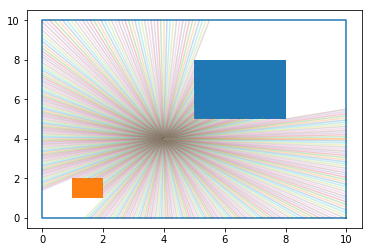

In [169]:
robot_location = (4,4)
distances, line_strings = synthetic_sensor(MAP, robot_location)
plot(MAP, robot_location, line_strings)

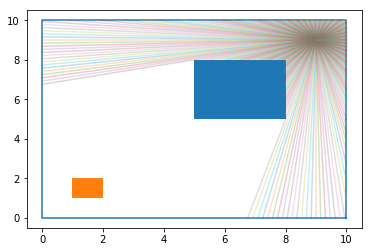

In [170]:
robot_location = (9,9)
distances, line_strings = synthetic_sensor(MAP, robot_location)
plot(MAP, robot_location, line_strings)

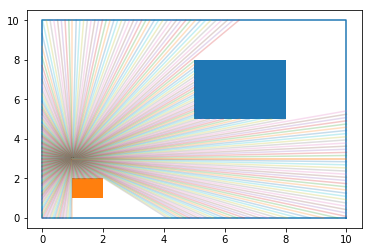

In [171]:
robot_location = (1,3)
distances, line_strings = synthetic_sensor(MAP, robot_location)
plot(MAP, robot_location, line_strings)